# PP-plot
Create a PP-plot to check if the sample works well. The idea behind is is that if the model, the prior and the sampler is correct then if you sample a parameter uniformly from the prior space, the fraction of recovery should be uniformly distributed too (e.g. 68% of the time, you should recover 68% of the parameters). In this example, of 10 synthetic datasets (ST model) in which only the mass parameter is inferred by UltraNest.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

In [7]:
def load_data(sample_number):
    # load sampling output file 
    data = np.loadtxt(f"../synthetic_data/dataset_{sample_number}/syndat_{sample_number}_output_no_background.txt")
    weights = data[:,0]
    masses = data[:,2]

    # get true mass  
    overview_file = np.loadtxt("../synthetic_data/syndat_overview.txt")
    true_mass = overview_file[sample_number-1][1] 

    return weights, masses, true_mass

For each output: 
1) Get the true value for the mass
2) Take all the weights of the masses that fall below that true value.
3) Sum up these weights
4) Store this output (should be a value between 0 and 1)/append this to a list.

That final list with credible intervals should be uniformly distributed if your sampler works correctly. 

In [11]:
N = 10 # sample size 
credible_levels = []

for i in np.arange(N):

    # get data 
    sample_number = i+1
    weights, masses, true_mass = load_data(sample_number)
 
    # get indices of all masses that fall below true mass 
    ind = np.where(masses < true_mass)

    # get corresponding weights 
    weights_below_true_mass = weights[ind]

    # store sum of these weights 
    credible_levels.append(np.sum(weights_below_true_mass)/np.sum(weights))

credible_levels = np.array(credible_levels)
credible_levels

array([0.51401959, 0.7021958 , 0.10586273, 0.67688451, 0.78351148,
       0.36212052, 0.28589812, 0.41402377, 0.90647217, 0.11710762])

Now to create the actual image of the PP-plot:
1) Create a list with evenly spaced bins (`np.linspace(0,1,1000)`)
2) Put the values of the list in these bins. So at bin 0.6 you should have roughly 60% of all the values in the list. 

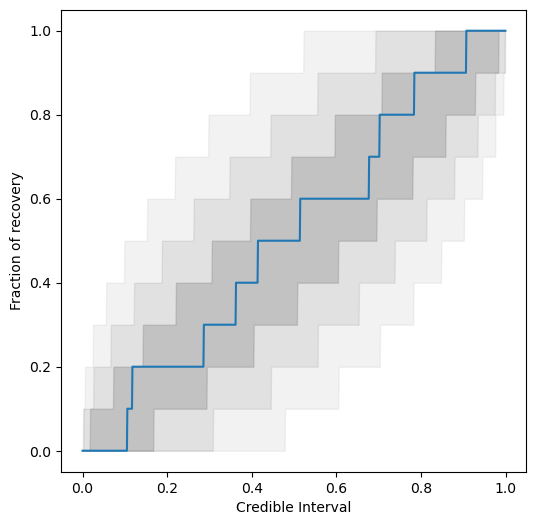

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

# plot lines 
x_values = np.linspace(0., 0.999, 1001)       
pp = np.array([sum(credible_levels < xx)/len(credible_levels) for xx in x_values])

# ax.plot(x_values, x_values)
ax.plot(x_values, pp)
ax.set_xlabel(r"Credible Interval")
ax.set_ylabel(r"Fraction of recovery")

# plot grey area 
confidence_interval=[0.68, 0.95, 0.997]
confidence_interval_alpha = [0.3,0.3/2,0.3/3]

for ci, alpha in zip(confidence_interval, confidence_interval_alpha):

    edge_of_bound = (1. - ci) / 2.
    lower = binom.ppf(1 - edge_of_bound, N, x_values) / N
    upper = binom.ppf(edge_of_bound, N, x_values) / N
    # The binomial point percent function doesn't always return 0 @ 0,
    # so set those bounds explicitly to be sure
    lower[0] = 0
    upper[0] = 0
    ax.fill_between(x_values, lower, upper, alpha=alpha, color='grey')

True mass: 1.3858796817826617 colortab:blue
True mass: 2.2791324782971913 colortab:orange
True mass: 1.2784010783662179 colortab:green
True mass: 1.5431231902689337 colortab:red
True mass: 2.0137948352882855 colortab:purple
True mass: 1.0904948310275742 colortab:brown
True mass: 1.9753146107787694 colortab:pink
True mass: 1.244018162021261 colortab:gray
True mass: 2.187067691149738 colortab:olive
True mass: 1.8418756781372545 colortab:cyan


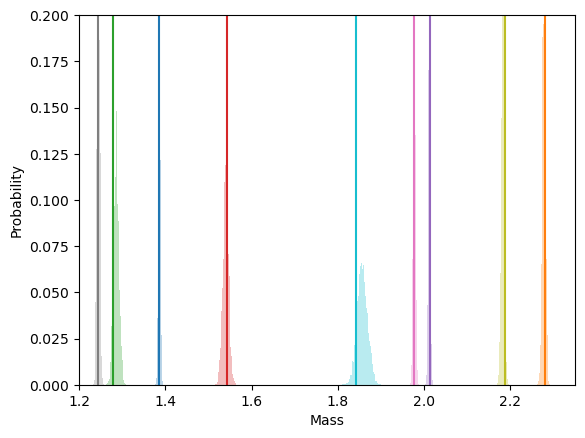

In [17]:
# Get an indication of the distribution
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

N = 10
for i in np.arange(N):

    sample_number = i+1
    weights, masses, true_mass = load_data(sample_number)
    
    # plt.hist(masses, bins=100,  color=colors[i], alpha=0.3)
    plt.hist(masses, weights=weights, bins=1000,  color=colors[i], alpha=0.3)
    plt.vlines(x=true_mass, ymin=0., ymax=1, colors=colors[i]);

    plt.xlim(1.2, 2.35)
    plt.ylim(0, 0.2)
    plt.xlabel("Mass")
    plt.ylabel("Probability")

    print("True mass:", true_mass, f"color{colors[i]}")

# Check residuals

Before the background was fixed to zero when inferring the mass, instead of having both the background and mass as free parameter, the PP-plot looked like shit. This is because when inferring the mass it has one other parameter it can compensate with, namely background. If you don't fix this background to zero (which is also what is used to create the data), then the background inferred will always be slightly above zero causing the mass itself to also be biased. Here we investigate such as result: 

difference in loglikelihood is roughly 11 for sample 1 with median mass vs true_mass 1.3966232089509354 1.3858796817826617 (difference: 0.010743527168273648). 

In [40]:
def load_data2(path):
    # load sampling output file 
    data = np.loadtxt(path)
    weights = data[:,0]
    masses = data[:,2]

    # get true mass  
    overview_file = np.loadtxt("../synthetic_data/syndat_overview.txt")
    true_mass = overview_file[sample_number-1][1] 

    return weights, masses, true_mass

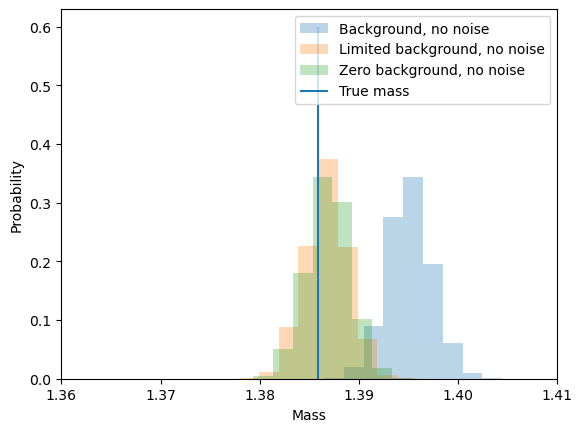

In [50]:
lim_weights, lim_masses, true_mass = load_data2("/home/mariska/Code/xpsi/tests/synthetic_data/dataset_1/syndat_1_output_limited_background_no_noise.txt")
no_weights, no_masses, true_mass = load_data2("/home/mariska/Code/xpsi/tests/synthetic_data/dataset_1/syndat_1_output_no_background_no_noise.txt")
weights, masses, true_mass = load_data2("/home/mariska/Code/xpsi/tests/synthetic_data/dataset_1/syndat_1_output_no_noise.txt")

plt.hist(masses, weights=weights, bins=1000, alpha=0.3, label="Background, no noise")
plt.hist(lim_masses, weights=lim_weights, bins=1000, alpha=0.3, label="Limited background, no noise")
plt.hist(no_masses, weights=no_weights, bins=1000, alpha=0.3, label="Zero background, no noise")

plt.vlines(x=true_mass, ymin=0., ymax=0.6, label="True mass");

plt.xlim(1.36, 1.41)
plt.xlabel("Mass")
plt.ylabel("Probability")
plt.legend()

Here we can see that if we don't fix the background to zero when doing the inference, the sampler overestimates the mass. This is because when the sampler only has one parameter to infer (namely mass in this case), it can only compensate by adjusting the background (which is the other parameters it tries to infer). /